# Homework

1. Train NN model with custom linear architecture on MNIST or on any dataset from Kaggle (image data with resolution not higher than 80x80 pixels - 
[Sign language MNIST](https://www.kaggle.com/datasets/datamunge/sign-language-mnist), 
[A-Z Handwritten Alphabet](https://www.kaggle.com/datasets/sachinpatel21/az-handwritten-alphabets-in-csv-format), etc.)
2. Visualize epoch progress (loss and accuracy curves)
3. Visualize 10 random elements from test set and model results for those elements

### Getting data 

In [349]:
import pandas as pd

In [350]:
def Get_sign_mnist_data():
    train_sign_mnist = pd.read_csv('data/sign_mnist_train.csv')
    test_sign_mnist = pd.read_csv('data/sign_mnist_test.csv')
    
    return train_sign_mnist, test_sign_mnist

train_df, test_df = Get_sign_mnist_data()
train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


In [351]:
test_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,6,149,149,150,150,150,151,151,150,151,...,138,148,127,89,82,96,106,112,120,107
1,5,126,128,131,132,133,134,135,135,136,...,47,104,194,183,186,184,184,184,182,180
2,10,85,88,92,96,105,123,135,143,147,...,68,166,242,227,230,227,226,225,224,222
3,0,203,205,207,206,207,209,210,209,210,...,154,248,247,248,253,236,230,240,253,255
4,3,188,191,193,195,199,201,202,203,203,...,26,40,64,48,29,46,49,46,46,53


## Data preparation

In [352]:
import torch
import torchvision
from PIL import Image

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [353]:
import torchvision.transforms as transforms

In [354]:
transform = torchvision.transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

### Labels preapration

In [355]:
sorted(train_df['label'].unique())

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24]

In [356]:
sorted(test_df['label'].unique())

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24]

In [357]:
# there is a 9:J and 25:Z gap in column label
train_df['label'] = train_df['label'].apply(lambda x: x if x < 10 else x - 1)
test_df['label'] = test_df['label'].apply(lambda x: x if x < 10 else x - 1)

### Datasets

In [358]:
import numpy as np

In [359]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, df, transform = None):
        self.df = df
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        label = self.df.iloc[idx, 0]
        image = np.array(self.df.iloc[idx, 1:]).reshape(28, 28, 1).astype(np.uint8).reshape((28,28,1))
        image = Image.fromarray(image.squeeze())
        
        if self.transform:
            image = self.transform(image)
        
        return image, label
        

In [360]:
import matplotlib.pyplot as plt
import numpy as np

3

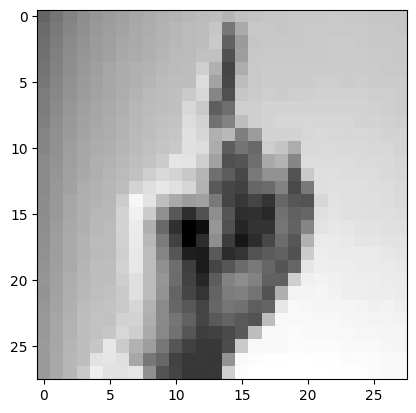

In [361]:
train_set = Dataset(train_df, transform=transform)
first_img_train, first_label_train = train_set[0]

plt.imshow(np.squeeze(first_img_train), cmap='gray')
first_label_train

6

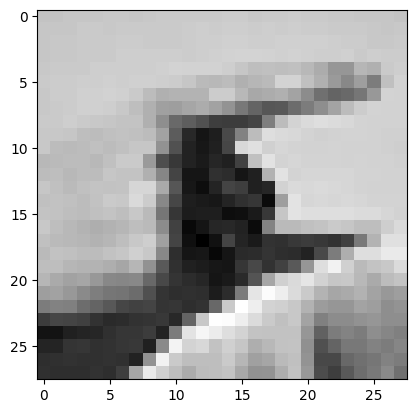

In [362]:
test_set = Dataset(test_df, transform=transform)
first_img_test, first_label_test = test_set[0]

plt.imshow(np.squeeze(first_img_test), cmap='gray')
first_label_test

### Dataloader

In [363]:
from torch.utils.data import DataLoader

In [364]:
batch_size = 4

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=0)

### Labels

In [365]:
label_df = train_df[['label']].copy()
unique_labels = label_df['label'].unique()
label_mapping = {label: idx for idx, label in enumerate(unique_labels)}

In [366]:
input_size = torch.numel(train_set[0][0])
output_size = len(label_mapping)

input_size, output_size

(784, 24)

### Model architecture

In [367]:
from torch import nn

In [368]:
class Sign_mnist_neural_network(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, output_size),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [369]:
model = Sign_mnist_neural_network(input_size, output_size).to(device)
print(model)

Sign_mnist_neural_network(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=24, bias=True)
  )
)


### Loos function and Optimizer

In [370]:
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

### The Train Loop

In [371]:
from tqdm import tqdm

In [372]:
def train_loop(dataloader, model, loss_fn, optimizer, epoch):
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    
    tqdm_loader = tqdm(dataloader, unit="batch", desc=f"Epoch {epoch}", total=len(dataloader))
    for batch, (X, y) in enumerate(tqdm_loader):
        # Compute prediction and loss
        X, y = X.to(device), y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 1000 == 0:
            tqdm_loader.set_postfix(loss=loss.item())
            
    return loss.item()

### The Test Loop

In [373]:
def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    
    return correct

## Training

In [374]:
epoches = 15
loss_history, accuracies_history = [], []

for epoch in range(1, epoches + 1):
    loss_in_epoch = train_loop(train_loader, model, loss_function, optimizer, epoch)
    acc_in_epoch = test_loop(test_loader, model, loss_function)
    
    accuracies_history.append(acc_in_epoch)
    loss_history.append(loss_in_epoch)
    
torch.save(model, 'model.pth')

Epoch 1: 100%|██████████| 6864/6864 [01:13<00:00, 92.97batch/s, loss=2.78] 


Test Error: 
 Accuracy: 24.0%, Avg loss: 2.706721 



Epoch 2: 100%|██████████| 6864/6864 [01:13<00:00, 93.86batch/s, loss=1.78] 


Test Error: 
 Accuracy: 45.6%, Avg loss: 1.869121 



Epoch 3: 100%|██████████| 6864/6864 [01:17<00:00, 89.01batch/s, loss=0.493] 


Test Error: 
 Accuracy: 54.3%, Avg loss: 1.470171 



Epoch 4: 100%|██████████| 6864/6864 [01:13<00:00, 93.05batch/s, loss=1.06]  


Test Error: 
 Accuracy: 62.2%, Avg loss: 1.232784 



Epoch 5: 100%|██████████| 6864/6864 [01:21<00:00, 84.48batch/s, loss=0.162] 


Test Error: 
 Accuracy: 66.9%, Avg loss: 1.112577 



Epoch 6: 100%|██████████| 6864/6864 [01:17<00:00, 89.10batch/s, loss=0.563] 


Test Error: 
 Accuracy: 68.1%, Avg loss: 1.030804 



Epoch 7: 100%|██████████| 6864/6864 [01:17<00:00, 88.63batch/s, loss=0.0177] 


Test Error: 
 Accuracy: 69.1%, Avg loss: 0.977494 



Epoch 8: 100%|██████████| 6864/6864 [01:16<00:00, 90.05batch/s, loss=0.891] 


Test Error: 
 Accuracy: 71.4%, Avg loss: 0.935808 



Epoch 9: 100%|██████████| 6864/6864 [01:14<00:00, 92.53batch/s, loss=0.254] 


Test Error: 
 Accuracy: 73.3%, Avg loss: 0.903007 



Epoch 10: 100%|██████████| 6864/6864 [01:12<00:00, 94.53batch/s, loss=0.215]  


Test Error: 
 Accuracy: 73.3%, Avg loss: 0.906780 



Epoch 11: 100%|██████████| 6864/6864 [01:11<00:00, 95.51batch/s, loss=0.403]  


Test Error: 
 Accuracy: 73.3%, Avg loss: 0.911203 



Epoch 12: 100%|██████████| 6864/6864 [01:11<00:00, 96.66batch/s, loss=0.0377] 


Test Error: 
 Accuracy: 74.3%, Avg loss: 0.929298 



Epoch 13: 100%|██████████| 6864/6864 [01:09<00:00, 98.79batch/s, loss=0.101]  


Test Error: 
 Accuracy: 74.6%, Avg loss: 0.932456 



Epoch 14: 100%|██████████| 6864/6864 [01:09<00:00, 98.96batch/s, loss=0.06]   


Test Error: 
 Accuracy: 74.8%, Avg loss: 0.933659 



Epoch 15: 100%|██████████| 6864/6864 [01:10<00:00, 97.83batch/s, loss=0.24]   


Test Error: 
 Accuracy: 75.1%, Avg loss: 0.955932 



## Visualize epoch progress (loss and accuracy curves)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


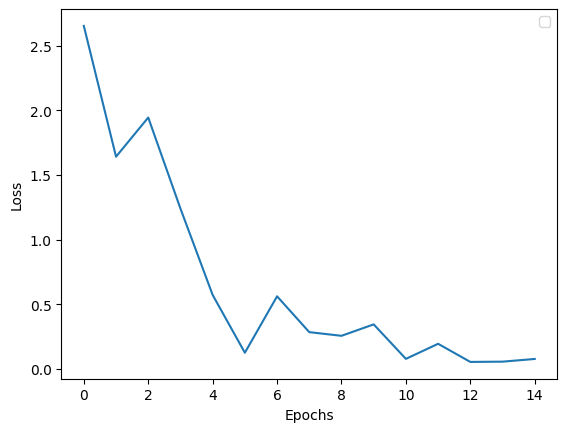

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


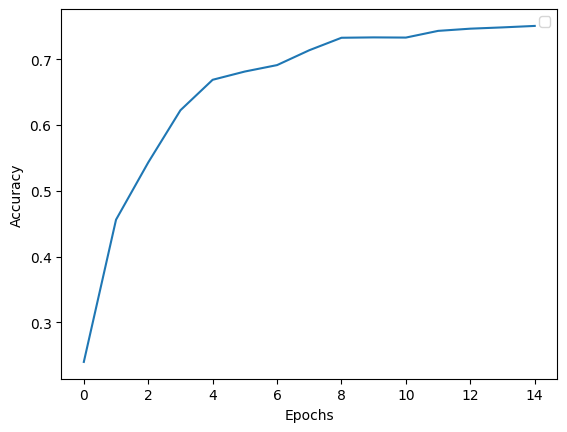

In [391]:
plt.plot(loss_history)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(accuracies_history)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

torch.save(model, 'model.pth')

## Visualize 10 random elements from test set and model results for those elements

Real: 21 Predicted: 21


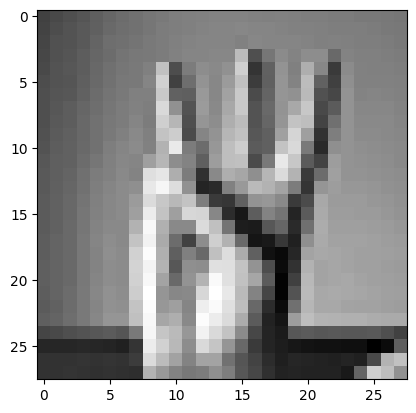

Real: 2 Predicted: 2


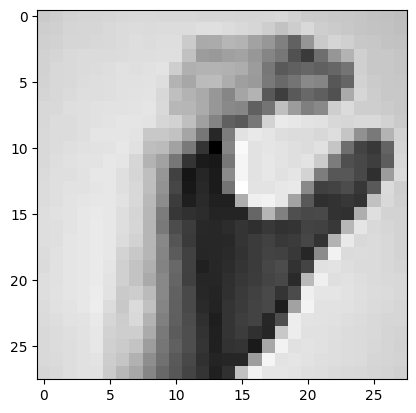

Real: 4 Predicted: 4


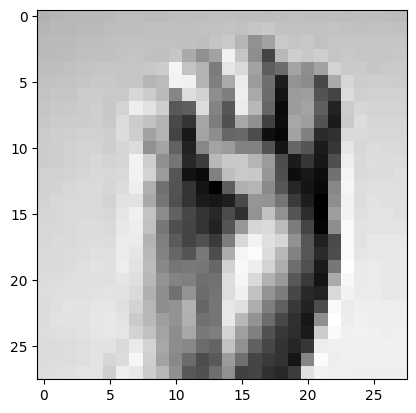

Real: 5 Predicted: 5


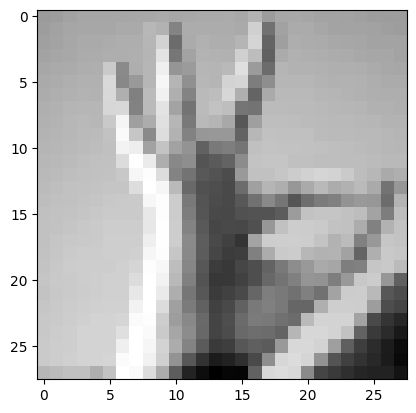

Real: 13 Predicted: 13


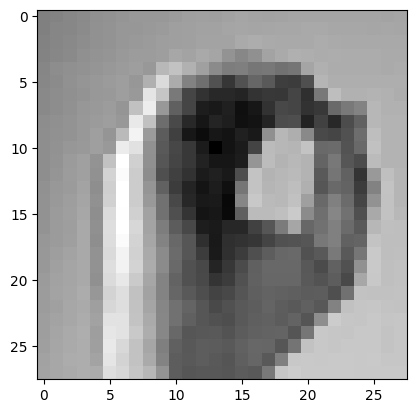

Real: 11 Predicted: 11


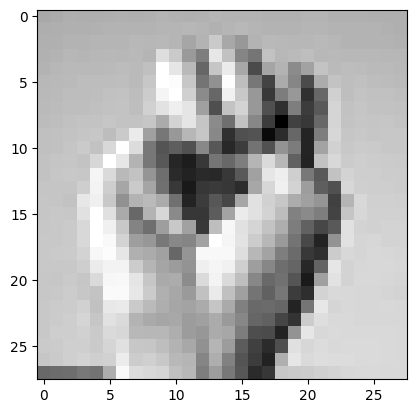

Real: 23 Predicted: 23


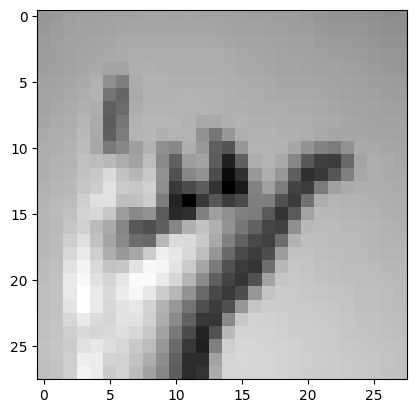

Real: 6 Predicted: 6


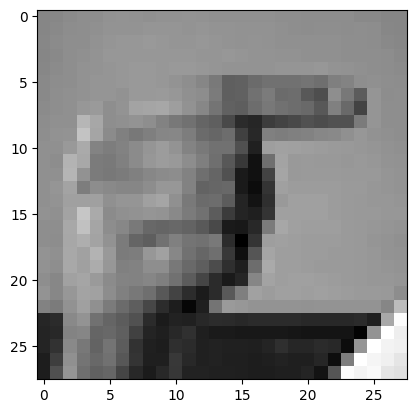

Real: 12 Predicted: 12


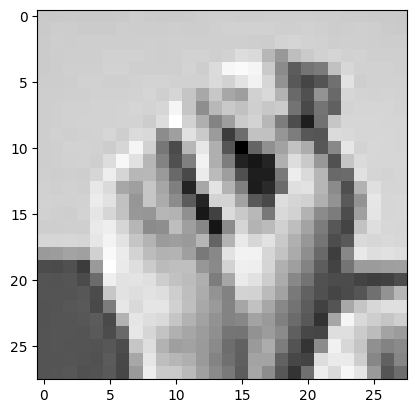

Real: 6 Predicted: 18


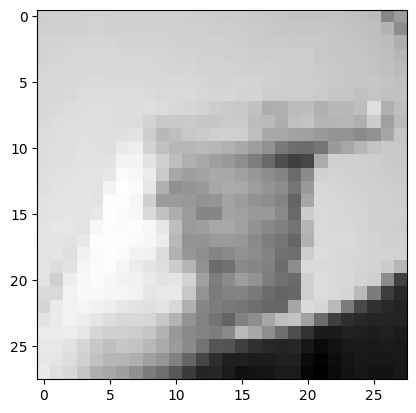

Real: 17 Predicted: 8


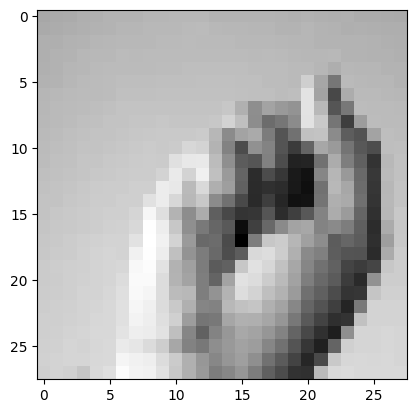

In [392]:
images = []
labels = []
model.eval()
test_loader = DataLoader(test_set, batch_size=1, shuffle=True, num_workers=0)


with torch.no_grad():
    while len(images) <= 10:
        image, label = next(iter(test_loader))
        predction = model(image.to(device))
        predction = predction.argmax(1)
        for i in range(len(predction)):
            images.append(image[i].cpu().numpy())
            labels.append({'real': label[i].item(), 'predicted': predction[i].item()})

for image, label in zip(images, labels):
    print(f'Real: {label["real"]} Predicted: {label["predicted"]}')
    plt.imshow(image.squeeze(), cmap='gray')
    plt.show()